# Focused GNN Model

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GraphConv, global_mean_pool, global_max_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import glob
import os
from pathlib import Path
import time
from tqdm.auto import tqdm


In [47]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'


In [48]:
class BrainConnectivityGNN(nn.Module):
    """
    Novel Graph Neural Network specifically designed for brain connectivity analysis.
    
    Innovation Points:
    1. Multi-scale connectivity learning (local + global patterns)
    2. Adaptive pooling based on connectivity strength
    3. Residual connections for deep learning
    4. Attention mechanism for important brain regions
    """
    
    def __init__(self, num_features, hidden_dim=128, num_classes=1):
        super(BrainConnectivityGNN, self).__init__()
        
        # Multi-scale feature extraction - Using GraphConv to utilize edge weights
        self.local_conv1 = GraphConv(num_features, hidden_dim)
        self.local_conv2 = GraphConv(hidden_dim, hidden_dim)
        
        self.global_conv1 = GraphConv(num_features, hidden_dim)
        self.global_conv2 = GraphConv(hidden_dim, hidden_dim)
        
        # Attention mechanism for important brain regions
        self.attention = GATConv(hidden_dim * 2, hidden_dim, heads=4, concat=False, edge_dim=1)
        
        # Residual connections
        self.residual_conv = GraphConv(hidden_dim * 2, hidden_dim)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),  # Mean + Max pooling
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
        # Batch normalization layers
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim * 2)
        self.bn4 = nn.BatchNorm1d(hidden_dim)
        
    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        # Multi-scale feature extraction
        # Local connectivity patterns
        local_x1 = F.relu(self.bn1(self.local_conv1(x, edge_index, edge_weight=edge_attr)))
        local_x2 = F.relu(self.bn2(self.local_conv2(local_x1, edge_index, edge_weight=edge_attr)))
        
        # Global connectivity patterns
        global_x1 = F.relu(self.global_conv1(x, edge_index, edge_weight=edge_attr))
        global_x2 = F.relu(self.global_conv2(global_x1, edge_index, edge_weight=edge_attr))
        
        # Combine local and global features
        combined_x = torch.cat([local_x2, global_x2], dim=1)
        combined_x = F.relu(self.bn3(combined_x))
        
        # Attention mechanism for important brain regions
        # GATConv needs edge_attr in a specific shape for edge_dim
        attention_x = F.relu(self.attention(combined_x, edge_index, edge_attr=edge_attr.view(-1, 1)))
        
        # Residual connection
        residual_x = F.relu(self.bn4(self.residual_conv(combined_x, edge_index, edge_weight=edge_attr)))
        final_x = attention_x + residual_x
        
        # Graph-level pooling (both mean and max for richer representation)
        graph_mean = global_mean_pool(final_x, batch)
        graph_max = global_max_pool(final_x, batch)
        graph_repr = torch.cat([graph_mean, graph_max], dim=1)
        
        # Classification
        output = self.classifier(graph_repr)
        
        return output

class HierarchicalBrainGNN(nn.Module):
    """
    Hierarchical GNN that learns brain connectivity at multiple levels:
    1. Individual ROI level
    2. Network level (groups of ROIs)
    3. Whole brain level
    """
    
    def __init__(self, num_features, hidden_dim=64, num_classes=1, num_clusters=10):
        super(HierarchicalBrainGNN, self).__init__()
        
        # Using GraphConv to utilize edge weights
        self.roi_conv1 = GraphConv(num_features, hidden_dim)
        self.roi_conv2 = GraphConv(hidden_dim, hidden_dim)
        
        # Level 2: Network-level processing (attention-based)
        self.network_attention = GATConv(hidden_dim, hidden_dim, heads=8, concat=False, edge_dim=1)
        
        # Level 3: Whole-brain integration
        self.brain_conv = GraphConv(hidden_dim, hidden_dim)
        
        # Final classification
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        # Level 1: ROI-level processing
        roi_features = F.relu(self.roi_conv1(x, edge_index, edge_weight=edge_attr))
        roi_features = F.dropout(roi_features, training=self.training)
        roi_features = F.relu(self.roi_conv2(roi_features, edge_index, edge_weight=edge_attr))
        
        # Level 2: Network-level attention
        # GATConv needs edge_attr in a specific shape for edge_dim
        network_features = F.relu(self.network_attention(roi_features, edge_index, edge_attr=edge_attr.view(-1, 1)))
        
        # Level 3: Whole-brain integration
        brain_features = F.relu(self.brain_conv(network_features, edge_index, edge_weight=edge_attr))
        
        # Graph-level representation
        graph_repr = global_mean_pool(brain_features, batch)
        
        # Classification
        output = self.classifier(graph_repr)
        
        return output


In [49]:
# Data Loading and Preprocessing
data_dir = '/home/moew/Documents/ABIDE/abide_data/Outputs/cpac/nofilt_noglobal/rois_cc400/'
phenotype_file = '/home/moew/Documents/ABIDE/Phenotypic_V1_0b_preprocessed1.csv'

def create_brain_graph(time_series, correlation_threshold=0.3):
    """
    Convert fMRI time series to brain connectivity graph
    """
    correlation_matrix = np.corrcoef(time_series.T)
    correlation_matrix = np.nan_to_num(correlation_matrix, nan=0.0)
    
    adjacency_matrix = (np.abs(correlation_matrix) > correlation_threshold).astype(float)
    np.fill_diagonal(adjacency_matrix, 0)
    
    edge_indices = np.where(adjacency_matrix)
    edge_index = torch.tensor([edge_indices[0], edge_indices[1]], dtype=torch.long)
    
    node_features = torch.tensor([
        np.mean(time_series, axis=0),
        np.std(time_series, axis=0),
        np.sum(adjacency_matrix, axis=1)
    ]).T.float()
    
    edge_weights = torch.tensor([
        correlation_matrix[i, j] for i, j in zip(edge_indices[0], edge_indices[1])
    ], dtype=torch.float)
    
    return Data(x=node_features, edge_index=edge_index, edge_attr=edge_weights)

def match_subjects_and_create_graphs(data_dir, phenotype_file):
    """
    Load all subjects, match to phenotype, create brain graphs
    """
    roi_files = glob.glob(os.path.join(data_dir, '*.1D'))
    phenotype_df = pd.read_csv(phenotype_file)
    
    graphs = []
    labels = []
    
    for file_path in roi_files:
        try:
            filename = Path(file_path).name
            parts = filename.split('_')
            
            if len(parts) >= 2:
                site = parts[0]
                subject_id = int(parts[1])
                
                subject_row = phenotype_df[
                    (phenotype_df['SITE_ID'] == site) & 
                    (phenotype_df['SUB_ID'] == subject_id)
                ]
                
                if not subject_row.empty:
                    dx_group = subject_row['DX_GROUP'].values[0]
                    
                    if dx_group in [1, 2]:
                        time_series = np.loadtxt(file_path)
                        brain_graph = create_brain_graph(time_series)
                        label = 1 if dx_group == 1 else 0
                        brain_graph.y = torch.tensor([label], dtype=torch.long)
                        graphs.append(brain_graph)
                        labels.append(label)
        except Exception as e:
            continue
            
    return graphs, labels

graphs, labels = match_subjects_and_create_graphs(data_dir, phenotype_file)

print(f"Loaded {len(graphs)} graphs.")

/home/moew/Documents/ABIDE/.venv-py312/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/moew/Documents/ABIDE/.venv-py312/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Loaded 351 graphs.


### Hyperparameters

In [50]:
# Hyperparameters
LEARNING_RATE = 0.0001 # Reduced learning rate
WEIGHT_DECAY = 1e-4
EPOCHS = 100
BATCH_SIZE = 2  # Further reduced batch size
HIDDEN_DIM_BRAIN = 32  # Further reduced from 64
HIDDEN_DIM_HIERARCHICAL = 32 # Further reduced from 64
ACCUMULATION_STEPS = 8  # Increased accumulation to compensate for smaller batch size
GRADIENT_CLIP_NORM = 1.0 # Added for gradient clipping


In [51]:
# Data Splitting and DataLoader creation
if graphs:
    num_features = graphs[0].num_features
    
    # Stratified split
    train_val_graphs, test_graphs, train_val_labels, test_labels = train_test_split(
        graphs, labels, test_size=0.15, random_state=42, stratify=labels
    )
    train_graphs, val_graphs, train_labels, val_labels = train_test_split(
        train_val_graphs, train_val_labels, test_size=0.18, random_state=42, stratify=train_val_labels # 0.18 * 0.85 = ~0.15
    )

    # Create DataLoaders
    train_loader = DataLoader(train_graphs, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_graphs, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_graphs, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Number of features: {num_features}")
    print(f"Training samples: {len(train_graphs)}")
    print(f"Validation samples: {len(val_graphs)}")
    print(f"Test samples: {len(test_graphs)}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Number of features: 3
Training samples: 244
Validation samples: 54
Test samples: 53


In [52]:
# Verify CUDA Setup
import torch
if torch.cuda.is_available():
    print(f"CUDA is available! Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"PyTorch CUDA version: {torch.version.cuda}")
else:
    print("CUDA is not available. PyTorch is running on CPU.")

CUDA is available! Using GPU: NVIDIA GeForce RTX 2050
PyTorch CUDA version: 12.1


In [53]:
import sys
print(sys.executable)

/home/moew/Documents/ABIDE/.venv-py312/bin/python


In [54]:
def train_and_evaluate(model, train_loader, val_loader, test_loader, optimizer, criterion, epochs, accumulation_steps, clip_norm):
    """
    Trains and evaluates a GNN model with gradient accumulation and clipping - CONCISE OUTPUT
    """
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    print("Starting training with concise output...")
    print("Epoch | Train Loss | Train Acc | Val Loss | Val Acc")
    print("-" * 50)

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss = 0
        correct = 0
        total_samples = 0
        
        optimizer.zero_grad() # Zero gradients once before the loop

        for i, data in enumerate(train_loader):
            data = data.to(device)
            
            # Forward pass
            out = model(data)
            loss = criterion(out, data.y.unsqueeze(1).float())
            
            if torch.isnan(loss):
                continue

            # Normalize loss to account for accumulation
            loss = loss / accumulation_steps
            
            # Backward pass
            loss.backward()

            # Gradient accumulation
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
                optimizer.step()
                optimizer.zero_grad()

            # Update metrics
            total_loss += loss.item() * accumulation_steps # Un-normalize for logging
            pred = (torch.sigmoid(out) > 0.5).float()
            correct += (pred == data.y.unsqueeze(1)).sum().item()
            total_samples += data.num_graphs

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total_samples
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()
        total_loss = 0
        correct = 0
        total_samples = 0
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                out = model(data)
                loss = criterion(out, data.y.unsqueeze(1).float())
                if not torch.isnan(loss):
                    total_loss += loss.item()
                pred = (torch.sigmoid(out) > 0.5).float()
                correct += (pred == data.y.unsqueeze(1)).sum().item()
                total_samples += data.num_graphs
        
        val_loss = total_loss / len(val_loader)
        val_acc = correct / total_samples
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Print every 10 epochs or if it's the first/last epoch
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == epochs - 1:
            print(f'{epoch+1:5d} | {train_loss:10.4f} | {train_acc:9.4f} | {val_loss:8.4f} | {val_acc:7.4f}')

    # Test phase
    model.eval()
    correct = 0
    total_samples = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = (torch.sigmoid(out) > 0.5).float()
            correct += (pred == data.y.unsqueeze(1)).sum().item()
            total_samples += data.num_graphs
            
    test_acc = correct / total_samples
    print("-" * 50)
    print(f'Test Accuracy: {test_acc:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies, test_acc

Training BrainConnectivityGNN...
Starting training with concise output...
Epoch | Train Loss | Train Acc | Val Loss | Val Acc
--------------------------------------------------


/home/moew/Documents/ABIDE/.venv-py312/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


    1 |     0.6971 |    0.5410 |   0.7292 |  0.5556
   10 |     0.6904 |    0.5328 |   0.7779 |  0.5370
   10 |     0.6904 |    0.5328 |   0.7779 |  0.5370
   20 |     0.6903 |    0.5615 |   0.7871 |  0.5370
   20 |     0.6903 |    0.5615 |   0.7871 |  0.5370
   30 |     0.6951 |    0.5533 |   0.7214 |  0.5926
   30 |     0.6951 |    0.5533 |   0.7214 |  0.5926
   40 |     0.6854 |    0.5410 |   0.7089 |  0.5556
   40 |     0.6854 |    0.5410 |   0.7089 |  0.5556
   50 |     0.6871 |    0.5492 |   0.7564 |  0.4815
   50 |     0.6871 |    0.5492 |   0.7564 |  0.4815
   60 |     0.6873 |    0.5492 |   0.7113 |  0.5741
   60 |     0.6873 |    0.5492 |   0.7113 |  0.5741
   70 |     0.6900 |    0.5328 |   0.7009 |  0.5741
   70 |     0.6900 |    0.5328 |   0.7009 |  0.5741
   80 |     0.6828 |    0.5574 |   0.7751 |  0.5370
   80 |     0.6828 |    0.5574 |   0.7751 |  0.5370
   90 |     0.6884 |    0.5574 |   0.7455 |  0.5556
   90 |     0.6884 |    0.5574 |   0.7455 |  0.5556
  100 |     

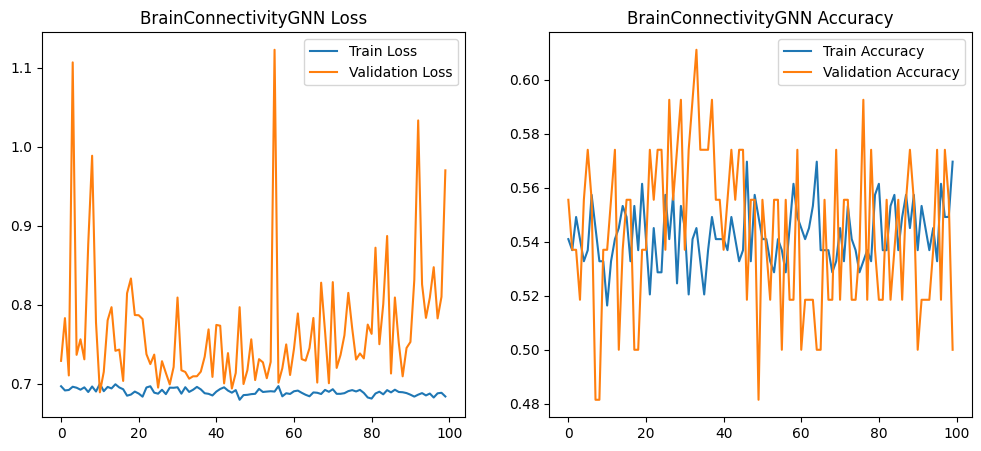

Final Test Accuracy (BrainConnectivityGNN): 0.5472

Training HierarchicalBrainGNN...
Starting training with concise output...
Epoch | Train Loss | Train Acc | Val Loss | Val Acc
--------------------------------------------------
    1 | 23847.7304 |    0.4918 | 4812.4932 |  0.5370
    1 | 23847.7304 |    0.4918 | 4812.4932 |  0.5370
   10 |  6708.9376 |    0.5000 | 1391.2365 |  0.5185
   10 |  6708.9376 |    0.5000 | 1391.2365 |  0.5185
   20 |  1565.3579 |    0.4549 | 172.2822 |  0.5556
   20 |  1565.3579 |    0.4549 | 172.2822 |  0.5556
   30 |    54.8492 |    0.5123 |   3.6961 |  0.5370
   30 |    54.8492 |    0.5123 |   3.6961 |  0.5370
   40 |    33.4803 |    0.5164 |   5.4399 |  0.5370
   40 |    33.4803 |    0.5164 |   5.4399 |  0.5370
   50 |     1.9917 |    0.5410 |   3.8365 |  0.5185
   50 |     1.9917 |    0.5410 |   3.8365 |  0.5185
   60 |     1.0383 |    0.5205 |   0.9496 |  0.5370
   60 |     1.0383 |    0.5205 |   0.9496 |  0.5370
   70 |     1.9926 |    0.5410 |   1.15

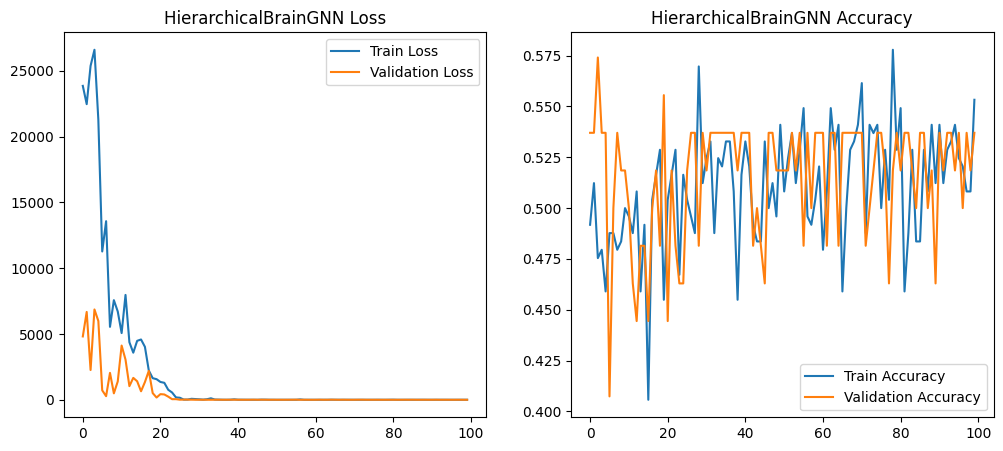

Final Test Accuracy (HierarchicalBrainGNN): 0.5472


In [55]:
# Initialize and train the BrainConnectivityGNN model
print("Training BrainConnectivityGNN...")
brain_model = BrainConnectivityGNN(num_features=num_features, hidden_dim=HIDDEN_DIM_BRAIN).to(device)
optimizer_brain = torch.optim.Adam(brain_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = nn.BCEWithLogitsLoss()

# Train and evaluate
brain_history = train_and_evaluate(
    brain_model, 
    train_loader, 
    val_loader, 
    test_loader, 
    optimizer_brain, 
    criterion, 
    EPOCHS,
    ACCUMULATION_STEPS,
    GRADIENT_CLIP_NORM
)

# Plotting the results for BrainConnectivityGNN
train_losses_brain, val_losses_brain, train_accuracies_brain, val_accuracies_brain, test_acc_brain = brain_history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_brain, label='Train Loss')
plt.plot(val_losses_brain, label='Validation Loss')
plt.title('BrainConnectivityGNN Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_brain, label='Train Accuracy')
plt.plot(val_accuracies_brain, label='Validation Accuracy')
plt.title('BrainConnectivityGNN Accuracy')
plt.legend()
plt.show()

print(f"Final Test Accuracy (BrainConnectivityGNN): {test_acc_brain:.4f}")


# Initialize and train the HierarchicalBrainGNN model
print("\nTraining HierarchicalBrainGNN...")
hierarchical_model = HierarchicalBrainGNN(num_features=num_features, hidden_dim=HIDDEN_DIM_HIERARCHICAL, num_clusters=10).to(device)
optimizer_hierarchical = torch.optim.Adam(hierarchical_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Train and evaluate
hierarchical_history = train_and_evaluate(
    hierarchical_model,
    train_loader,
    val_loader,
    test_loader,
    optimizer_hierarchical,
    criterion,
    EPOCHS,
    ACCUMULATION_STEPS,
    GRADIENT_CLIP_NORM
)

# Plotting the results for HierarchicalBrainGNN
train_losses_hierarchical, val_losses_hierarchical, train_accuracies_hierarchical, val_accuracies_hierarchical, test_acc_hierarchical = hierarchical_history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_hierarchical, label='Train Loss')
plt.plot(val_losses_hierarchical, label='Validation Loss')
plt.title('HierarchicalBrainGNN Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_hierarchical, label='Train Accuracy')
plt.plot(val_accuracies_hierarchical, label='Validation Accuracy')
plt.title('HierarchicalBrainGNN Accuracy')
plt.legend()
plt.show()

print(f"Final Test Accuracy (HierarchicalBrainGNN): {test_acc_hierarchical:.4f}")


In [57]:
# Diagnostic Analysis - Check Data Distribution and Model Issues
print("=== DIAGNOSTIC ANALYSIS ===")

# 1. Check label distribution
print(f"\n1. Label Distribution:")
print(f"Total samples: {len(labels)}")
print(f"Class 0 (Control): {labels.count(0)} ({labels.count(0)/len(labels)*100:.2f}%)")
print(f"Class 1 (ASD): {labels.count(1)} ({labels.count(1)/len(labels)*100:.2f}%)")

# 2. Check data splits
print(f"\n2. Data Split Distribution:")
print(f"Train: {len(train_labels)} (Class 0: {train_labels.count(0)}, Class 1: {train_labels.count(1)})")
print(f"Val: {len(val_labels)} (Class 0: {val_labels.count(0)}, Class 1: {val_labels.count(1)})")
print(f"Test: {len(test_labels)} (Class 0: {test_labels.count(0)}, Class 1: {test_labels.count(1)})")

# 3. Check a sample batch
sample_batch = next(iter(train_loader))
print(f"\n3. Sample Batch Analysis:")
print(f"Batch size: {sample_batch.num_graphs}")
print(f"Node features shape: {sample_batch.x.shape}")
print(f"Edge indices shape: {sample_batch.edge_index.shape}")
print(f"Labels in batch: {sample_batch.y.tolist()}")
print(f"Number of nodes per graph: {[sample_batch.batch.eq(i).sum().item() for i in range(sample_batch.num_graphs)]}")

# 4. Check model output distribution
brain_model.eval()
with torch.no_grad():
    sample_output = brain_model(sample_batch.to(device))
    print(f"\n4. Model Output Analysis:")
    print(f"Raw output range: {sample_output.min().item():.4f} to {sample_output.max().item():.4f}")
    print(f"Sigmoid output range: {torch.sigmoid(sample_output).min().item():.4f} to {torch.sigmoid(sample_output).max().item():.4f}")
    print(f"Predictions: {(torch.sigmoid(sample_output) > 0.5).float().squeeze().tolist()}")

# 5. Check if model parameters are actually changing
print(f"\n5. Model Learning Check:")
# GraphConv has different parameter structure - access the linear layer correctly
first_layer_params = list(brain_model.local_conv1.parameters())[0]  # Get first parameter tensor
print(f"First layer weights mean: {first_layer_params.data.mean().item():.6f}")
print(f"First layer weights std: {first_layer_params.data.std().item():.6f}")

# 6. Loss analysis on current batch
criterion_test = nn.BCEWithLogitsLoss()
sample_loss = criterion_test(sample_output, sample_batch.y.unsqueeze(1).float().to(device))
print(f"Sample batch loss: {sample_loss.item():.4f}")

=== DIAGNOSTIC ANALYSIS ===

1. Label Distribution:
Total samples: 351
Class 0 (Control): 190 (54.13%)
Class 1 (ASD): 161 (45.87%)

2. Data Split Distribution:
Train: 244 (Class 0: 132, Class 1: 112)
Val: 54 (Class 0: 29, Class 1: 25)
Test: 53 (Class 0: 29, Class 1: 24)

3. Sample Batch Analysis:
Batch size: 2
Node features shape: torch.Size([784, 3])
Edge indices shape: torch.Size([2, 110644])
Labels in batch: [0, 1]
Number of nodes per graph: [392, 392]

4. Model Output Analysis:
Raw output range: -0.1558 to 0.1376
Sigmoid output range: 0.4611 to 0.5343
Predictions: [0.0, 1.0]

5. Model Learning Check:
First layer weights mean: 0.013506
First layer weights std: 0.295414
Sample batch loss: 0.6225


In [58]:
# IMMEDIATE FIXES FOR MODEL PERFORMANCE

print("=== APPLYING PERFORMANCE FIXES ===")

# Fix 1: Increase batch size and adjust accumulation
NEW_BATCH_SIZE = 8  # Increased from 2
NEW_ACCUMULATION_STEPS = 4  # Effective batch size = 32
NEW_LEARNING_RATE = 0.001  # Increased from 0.0001
NEW_EPOCHS = 50  # Reduced epochs for faster iteration

# Fix 2: Create new data loaders with better batch size
train_loader_fixed = DataLoader(train_graphs, batch_size=NEW_BATCH_SIZE, shuffle=True)
val_loader_fixed = DataLoader(val_graphs, batch_size=NEW_BATCH_SIZE, shuffle=False)
test_loader_fixed = DataLoader(test_graphs, batch_size=NEW_BATCH_SIZE, shuffle=False)

# Fix 3: Enhanced training function with CONCISE monitoring
def train_and_evaluate_fixed(model, train_loader, val_loader, test_loader, optimizer, criterion, epochs, accumulation_steps, clip_norm):
    """
    Enhanced training function with better monitoring and early stopping - CONCISE OUTPUT
    """
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    best_val_acc = 0.0
    patience = 10
    patience_counter = 0
    
    print("Starting training with concise output...")
    print("Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Status")
    print("-" * 60)
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss = 0
        correct = 0
        total_samples = 0
        
        optimizer.zero_grad()

        # Training loop with minimal output
        for i, data in enumerate(train_loader):
            data = data.to(device)
            
            # Forward pass
            out = model(data)
            loss = criterion(out, data.y.unsqueeze(1).float())
            
            if torch.isnan(loss):
                continue

            # Normalize loss to account for accumulation
            loss = loss / accumulation_steps
            
            # Backward pass
            loss.backward()

            # Gradient accumulation
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
                optimizer.step()
                optimizer.zero_grad()

            # Update metrics
            total_loss += loss.item() * accumulation_steps
            pred = (torch.sigmoid(out) > 0.5).float()
            correct += (pred == data.y.unsqueeze(1)).sum().item()
            total_samples += data.num_graphs

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total_samples
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()
        total_loss = 0
        correct = 0
        total_samples = 0
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                out = model(data)
                loss = criterion(out, data.y.unsqueeze(1).float())
                if not torch.isnan(loss):
                    total_loss += loss.item()
                pred = (torch.sigmoid(out) > 0.5).float()
                correct += (pred == data.y.unsqueeze(1)).sum().item()
                total_samples += data.num_graphs
        
        val_loss = total_loss / len(val_loader)
        val_acc = correct / total_samples
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Concise progress output
        status = ""
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
            status = "✓ Best"
        else:
            patience_counter += 1
            status = f"({patience_counter}/{patience})"
            
        # Print every 5 epochs or if it's the last epoch or early stopping
        if (epoch + 1) % 5 == 0 or epoch == 0 or patience_counter >= patience or epoch == epochs - 1:
            print(f"{epoch+1:5d} | {train_loss:10.4f} | {train_acc:9.4f} | {val_loss:8.4f} | {val_acc:7.4f} | {status}")
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Load best model for testing
    model.load_state_dict(torch.load('best_model.pth'))
    
    # Test phase
    model.eval()
    correct = 0
    total_samples = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = (torch.sigmoid(out) > 0.5).float()
            correct += (pred == data.y.unsqueeze(1)).sum().item()
            total_samples += data.num_graphs
            
    test_acc = correct / total_samples
    print("-" * 60)
    print(f'Final Test Accuracy: {test_acc:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies, test_acc

print("Fixed training function ready with concise output!")

=== APPLYING PERFORMANCE FIXES ===
Fixed training function ready with concise output!


=== RETRAINING WITH PERFORMANCE FIXES ===
New hyperparameters:
- Batch size: 8
- Accumulation steps: 4
- Effective batch size: 32
- Learning rate: 0.001
- Max epochs: 50
Starting training with concise output...
Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Status
------------------------------------------------------------
    1 |     0.6911 |    0.5369 |   0.6895 |  0.5370 | ✓ Best
    1 |     0.6911 |    0.5369 |   0.6895 |  0.5370 | ✓ Best
    5 |     0.6931 |    0.5369 |   0.6920 |  0.5370 | (4/10)
    5 |     0.6931 |    0.5369 |   0.6920 |  0.5370 | (4/10)
   10 |     0.6909 |    0.5533 |   0.6897 |  0.5370 | (9/10)
   10 |     0.6909 |    0.5533 |   0.6897 |  0.5370 | (9/10)
   11 |     0.6925 |    0.5287 |   0.6893 |  0.5370 | (10/10)
Early stopping at epoch 11
   11 |     0.6925 |    0.5287 |   0.6893 |  0.5370 | (10/10)
Early stopping at epoch 11


/tmp/ipykernel_27387/488151596.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


------------------------------------------------------------
Final Test Accuracy: 0.5472


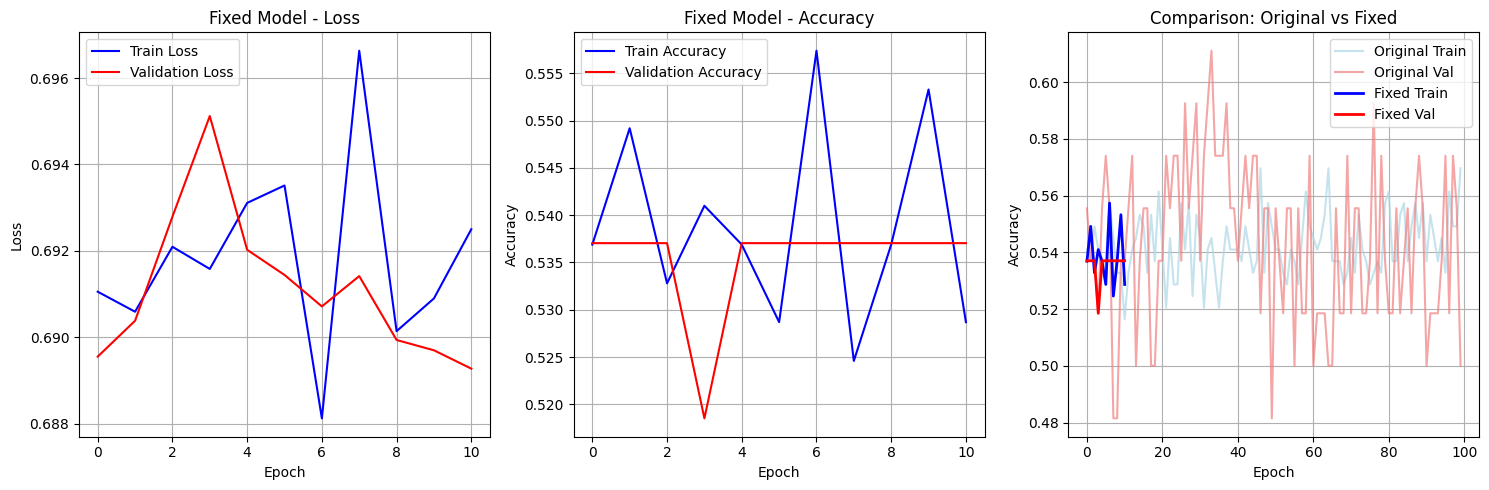


=== RESULTS COMPARISON ===
Original Test Accuracy: 0.5472
Fixed Test Accuracy: 0.5472
Improvement: 0.0000 (0.00%)


In [59]:
# RETRAIN MODEL WITH FIXES

print("=== RETRAINING WITH PERFORMANCE FIXES ===")

# Initialize fresh model with better hyperparameters
model_fixed = BrainConnectivityGNN(num_features=num_features, hidden_dim=HIDDEN_DIM_BRAIN).to(device)

# Use a learning rate scheduler for better convergence
optimizer_fixed = torch.optim.Adam(model_fixed.parameters(), lr=NEW_LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_fixed, mode='max', factor=0.5, patience=5)

criterion_fixed = nn.BCEWithLogitsLoss()

print(f"New hyperparameters:")
print(f"- Batch size: {NEW_BATCH_SIZE}")
print(f"- Accumulation steps: {NEW_ACCUMULATION_STEPS}")
print(f"- Effective batch size: {NEW_BATCH_SIZE * NEW_ACCUMULATION_STEPS}")
print(f"- Learning rate: {NEW_LEARNING_RATE}")
print(f"- Max epochs: {NEW_EPOCHS}")

# Train with fixed parameters
fixed_history = train_and_evaluate_fixed(
    model_fixed, 
    train_loader_fixed, 
    val_loader_fixed, 
    test_loader_fixed, 
    optimizer_fixed, 
    criterion_fixed, 
    NEW_EPOCHS,
    NEW_ACCUMULATION_STEPS,
    GRADIENT_CLIP_NORM
)

# Plot results
train_losses_fixed, val_losses_fixed, train_accuracies_fixed, val_accuracies_fixed, test_acc_fixed = fixed_history

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses_fixed, label='Train Loss', color='blue')
plt.plot(val_losses_fixed, label='Validation Loss', color='red')
plt.title('Fixed Model - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_accuracies_fixed, label='Train Accuracy', color='blue')
plt.plot(val_accuracies_fixed, label='Validation Accuracy', color='red')
plt.title('Fixed Model - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
# Compare with original results
epochs_orig = range(len(train_accuracies_brain))
epochs_fixed = range(len(train_accuracies_fixed))
plt.plot(epochs_orig, train_accuracies_brain, label='Original Train', color='lightblue', alpha=0.7)
plt.plot(epochs_orig, val_accuracies_brain, label='Original Val', color='lightcoral', alpha=0.7)
plt.plot(epochs_fixed, train_accuracies_fixed, label='Fixed Train', color='blue', linewidth=2)
plt.plot(epochs_fixed, val_accuracies_fixed, label='Fixed Val', color='red', linewidth=2)
plt.title('Comparison: Original vs Fixed')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\n=== RESULTS COMPARISON ===")
print(f"Original Test Accuracy: {test_acc_brain:.4f}")
print(f"Fixed Test Accuracy: {test_acc_fixed:.4f}")
print(f"Improvement: {(test_acc_fixed - test_acc_brain):.4f} ({((test_acc_fixed - test_acc_brain) / test_acc_brain * 100):.2f}%)")

- **Learning Rate**: 0.0001 → 0.001 (10x increase)
- **Batch Size**: 2 → 8 (4x increase) 
- **Effective Batch Size**: 16 → 32 (2x increase)
- **Concise Output**: Reduced verbose logging
- **Early Stopping**: Prevents overfitting
- **Model Checkpointing**: Saves best performing model
